# Performance Benchmark: WSI Patch Extraction (Publication-ready)

This notebook benchmarks the patch extraction pipeline (`src/preprocessing/extract_patches.py`) on randomly sampled whole-slide images (WSIs).

We measure per-slide wall-clock time and relate it to slide size (level-0 pixels), mask size (non-zero ROI pixels), and the number of extracted patches. The benchmark samples 15 valid slides (reproducible seed) and saves both the raw metrics and figures under `outputs/analyse/` for reporting.


In [1]:
# Benchmarks for `src/preprocessing/extract_patches.py` - imports and configuration
import os
import time
import gc
import math
import random
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Repo functions
from src.preprocessing.vanil_extract_patches import extract_patches
from src.preprocessing.load_wsi import load_wsi
from src.preprocessing.xml_to_mask import get_mask
from src.preprocessing.annotation_utils import resolve_annotation_path

# Configuration - adjust if needed
WSI_INDEX = 'outputs/index/wsi_index.csv'
OUT_DIR = Path('outputs/analyse')
OUT_DIR.mkdir(parents=True, exist_ok=True)
CSV_OUT = OUT_DIR / 'extract_patches_benchmark.csv'
PLOTS_DIR = OUT_DIR
N_SAMPLES = 15  # number of random slides to benchmark
PATCH_SIZE = 512
STRIDE = 512
TISSUE_THRESHOLD = 0.2
LEVEL = 0
RANDOM_SEED = 42

print(f"Benchmark config: N_SAMPLES={N_SAMPLES}, PATCH_SIZE={PATCH_SIZE}, STRIDE={STRIDE}, LEVEL={LEVEL}")


Benchmark config: N_SAMPLES=15, PATCH_SIZE=512, STRIDE=512, LEVEL=0


## Methods and design

- Sample N=15 slides uniformly at random from valid (WSI+annotation) entries in `outputs/index/wsi_index.csv` with a fixed seed for reproducibility.
- For each slide:
  - Build the ROI mask with `get_mask` and load the WSI via `load_wsi`.
  - Time `extract_patches` with `save_dir=None` (measures compute/IO without disk write).
  - Record: time_seconds, WSI dimensions (level-0), mask size (non-zero count), and number of extracted patches.
- Save a tidy CSV `outputs/analyse/extract_patches_benchmark.csv` for later graphing and a summary CSV with correlations.

Configuration below defines patch parameters, level, and sample size.


In [2]:
# Benchmark a single slide and return metrics (adds memory metrics)
import time
import os
import numpy as np
from typing import Optional
from src.preprocessing.load_wsi import load_wsi
from src.preprocessing.extract_patches import extract_patches
import inspect


def benchmark_slide(wsi_path: str, annotation_path: str,
                    level: int = LEVEL,
                    patch_size: int = PATCH_SIZE,
                    stride: int = STRIDE,
                    tissue_threshold: float = TISSUE_THRESHOLD,
                    log_memory_every: Optional[int] = 100,
                    memory_log_path: Optional[str] = None):
    """Run extract_patches for a single slide and return metrics dict.

    This variant records memory before/after the slide processing, computes mask stats,
    and requests per-patch memory logging from `extract_patches` (when `log_memory_every` is set).
    """
    metrics = {}
    if not (wsi_path and os.path.exists(wsi_path)):
        metrics['error'] = f'WSI missing: {wsi_path}'
        return metrics

    # record memory at start if helper available
    mem_before = None
    try:
        from src.utils import memory as memory_utils
        mem_before = memory_utils.get_memory_info()
    except Exception:
        mem_before = None

    t0 = time.time()

    # Try to build mask if a helper is available in the notebook scope
    mask = None
    try:
        mask = get_mask(annotation_path, wsi_path)
    except Exception:
        mask = None

    try:
        wsi = load_wsi(wsi_path)
    except Exception as e:
        metrics['error'] = f'load_wsi failed: {e}'
        return metrics

    lvl0_w, lvl0_h = wsi.level_dimensions[0]

    # Compute mask statistics if available
    mask_width = mask_height = mask_pixels = mask_nonzero = mask_fraction = None
    if mask is not None:
        try:
            mask_height, mask_width = mask.shape
            mask_pixels = int(mask_height * mask_width)
            mask_nonzero = int(np.sum(mask > 0))
            mask_fraction = float(mask_nonzero / mask_pixels) if mask_pixels > 0 else 0.0
        except Exception:
            pass

    # Compose a default per-patch memory log path if not supplied
    mp_log_path = str(OUT_DIR / 'memory_per_patch.csv') if memory_log_path is None else memory_log_path

    # slide identifier for logging
    slide_name = os.path.splitext(os.path.basename(str(wsi_path)))[0]

    # Build kwargs compatibly with the extract_patches signature
    ep_params = set(inspect.signature(extract_patches).parameters.keys())
    ep_kwargs = {
        'mask': mask,
        'size': patch_size,
        'stride': stride,
        'tissue_threshold': tissue_threshold,
        'level': level,
        'save_dir': None,
        'save_prefix': slide_name,
        'save_format': 'png',
    }
    if 'log_memory_every' in ep_params:
        ep_kwargs['log_memory_every'] = log_memory_every
    if 'memory_log_path' in ep_params:
        ep_kwargs['memory_log_path'] = mp_log_path
    if 'slide_id' in ep_params:
        ep_kwargs['slide_id'] = slide_name

    # Run extraction
    patches = extract_patches(wsi, **ep_kwargs)

    t1 = time.time()

    mem_after = None
    try:
        from src.utils import memory as memory_utils
        mem_after = memory_utils.get_memory_info()
    except Exception:
        mem_after = None

    # Compute memory deltas
    rss_delta = vms_delta = percent_delta = None
    if mem_before and mem_after:
        try:
            if mem_before.get('rss') is not None and mem_after.get('rss') is not None:
                rss_delta = mem_after['rss'] - mem_before['rss']
            if mem_before.get('vms') is not None and mem_after.get('vms') is not None:
                vms_delta = mem_after['vms'] - mem_before['vms']
            if mem_before.get('percent') is not None and mem_after.get('percent') is not None:
                percent_delta = mem_after['percent'] - mem_before['percent']
        except Exception:
            pass

    # Robust patch counting
    try:
        num_patches = len(patches) if patches is not None else 0
    except Exception:
        num_patches = 0

    metrics.update({
        'wsi_path': wsi_path,
        'annotation_path': annotation_path,
        'lvl0_width': int(lvl0_w),
        'lvl0_height': int(lvl0_h),
        'wsi_pixels': int(lvl0_w) * int(lvl0_h),
        'mask_width': mask_width,
        'mask_height': mask_height,
        'mask_pixels': mask_pixels,
        'mask_nonzero': mask_nonzero,
        'mask_fraction': mask_fraction,
        'patch_size': patch_size,
        'stride': stride,
        'num_patches': num_patches,
        'time_seconds': t1 - t0,
        'time_per_patch_s': (t1 - t0) / num_patches if num_patches > 0 else None,
        'mem_rss_before': mem_before.get('rss') if mem_before else None,
        'mem_rss_after': mem_after.get('rss') if mem_after else None,
        'mem_rss_delta': rss_delta,
        'mem_vms_before': mem_before.get('vms') if mem_before else None,
        'mem_vms_after': mem_after.get('vms') if mem_after else None,
        'mem_vms_delta': vms_delta,
        'mem_percent_before': mem_before.get('percent') if mem_before else None,
        'mem_percent_after': mem_after.get('percent') if mem_after else None,
        'mem_percent_delta': percent_delta,
    })

    # close WSI resource if supported
    try:
        if 'wsi' in locals() and hasattr(wsi, 'close'):
            wsi.close()
    except Exception:
        pass

    return metrics

In [3]:
print(f"Running benchmark on {N_SAMPLES} randomly selected slides (seed={RANDOM_SEED})")

if not os.path.exists(WSI_INDEX):
    raise FileNotFoundError(f"WSI index not found: {WSI_INDEX}")

wsi_df = pd.read_csv(WSI_INDEX)
sample_rows = wsi_df.sample(n=N_SAMPLES, random_state=RANDOM_SEED).to_dict('records')

collected = []
for idx, row in enumerate(sample_rows, start=1):
    slide_id = row.get('slide_id') if 'slide_id' in row else os.path.splitext(os.path.basename(str(row.get('wsi_path'))))[0]
    print(f"[{idx}/{len(sample_rows)}] Benchmarking: {slide_id}")
    metrics = benchmark_slide(row.get('wsi_path'), row.get('annotation_path'), 
                              log_memory_every=100, 
                              memory_log_path=str(OUT_DIR / 'memory_per_patch.csv'))
    if 'error' in metrics:
        print(f"  Skipped {slide_id} due to error: {metrics['error']}")
    metrics['slide_id'] = slide_id
    collected.append(metrics)

# Build dataframe and save
df_out = pd.DataFrame(collected)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)
CSV_OUT = OUT_DIR / 'extract_patches_benchmark.csv'
df_out.to_csv(CSV_OUT, index=False)
print(f"\nSaved per-slide benchmark to: {CSV_OUT}")
print(f"Columns: {list(df_out.columns)}")

Running benchmark on 15 randomly selected slides (seed=42)
[1/15] Benchmarking: Her2Neg_Case_56
[2/15] Benchmarking: Her2Neg_Case_74
[3/15] Benchmarking: Her2Neg_Case_34
[4/15] Benchmarking: TCGA-E2-A152-01Z-00-DX1
[5/15] Benchmarking: TCGA-D8-A1XK-01Z-00-DX1
[6/15] Benchmarking: S15-05979
[7/15] Benchmarking: S13-07627
[8/15] Benchmarking: Her2Neg_Case_10
[9/15] Benchmarking: TCGA-AR-A1AY-01Z-00-DX1
[10/15] Benchmarking: Her2Neg_Case_71
[11/15] Benchmarking: Her2Neg_Case_79
[12/15] Benchmarking: TCGA-E2-A14V-01Z-00-DX1
[13/15] Benchmarking: TCGA-C8-A26W-01Z-00-DX1
[14/15] Benchmarking: TCGA-D8-A1XY-01Z-00-DX1
[15/15] Benchmarking: TCGA-E9-A1RB-01Z-00-DX1

Saved per-slide benchmark to: outputs\analyse\extract_patches_benchmark.csv
Columns: ['wsi_path', 'annotation_path', 'lvl0_width', 'lvl0_height', 'wsi_pixels', 'mask_width', 'mask_height', 'mask_pixels', 'mask_nonzero', 'mask_fraction', 'patch_size', 'stride', 'num_patches', 'time_seconds', 'time_per_patch_s', 'mem_rss_before', 'mem_

In [4]:
# Summary statistics and correlations (publication table) - includes memory analysis
import pandas as pd
import numpy as np
from scipy import stats

if not CSV_OUT.exists():
    print(f"CSV not found at {CSV_OUT}. Run the runner cell first.")
else:
    df = pd.read_csv(CSV_OUT)
    # Ensure numeric types for all analysis columns
    numeric_cols = ['time_seconds', 'wsi_pixels', 'mask_nonzero', 'num_patches',
                    'mem_rss_delta', 'mem_vms_delta', 'mem_percent_delta']
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Basic summary for time per slide
    summary = {
        'n_slides': int(df.shape[0]),
        'time_seconds_mean': float(df['time_seconds'].mean(skipna=True)) if 'time_seconds' in df.columns else np.nan,
        'time_seconds_median': float(df['time_seconds'].median(skipna=True)) if 'time_seconds' in df.columns else np.nan,
        'time_seconds_std': float(df['time_seconds'].std(skipna=True)) if 'time_seconds' in df.columns else np.nan,
        'time_seconds_min': float(df['time_seconds'].min(skipna=True)) if 'time_seconds' in df.columns else np.nan,
        'time_seconds_max': float(df['time_seconds'].max(skipna=True)) if 'time_seconds' in df.columns else np.nan,
    }

    # Memory summary statistics (RSS delta in MB)
    if 'mem_rss_delta' in df.columns:
        rss_mb = df['mem_rss_delta'] / (1024 * 1024)  # convert bytes to MB
        summary.update({
            'mem_rss_delta_mb_mean': float(rss_mb.mean(skipna=True)),
            'mem_rss_delta_mb_median': float(rss_mb.median(skipna=True)),
            'mem_rss_delta_mb_std': float(rss_mb.std(skipna=True)),
            'mem_rss_delta_mb_max': float(rss_mb.max(skipna=True)),
        })

    # Correlations (Pearson and Spearman) to slide size, mask size, patch count
    corr_rows = []
    for feat in ['wsi_pixels', 'mask_nonzero', 'num_patches']:
        if feat not in df.columns or 'time_seconds' not in df.columns:
            continue
        sub = df[[feat, 'time_seconds']].dropna()
        if len(sub) >= 2:
            r_p, p_p = stats.pearsonr(sub[feat], sub['time_seconds'])
            r_s, p_s = stats.spearmanr(sub[feat], sub['time_seconds'])
            corr_rows.append({
                'feature': feat,
                'vs': 'time_seconds',
                'pearson_r': float(r_p), 'pearson_p': float(p_p),
                'spearman_r': float(r_s), 'spearman_p': float(p_s),
                'n': int(len(sub))
            })

    # Memory correlations (memory delta vs slide size)
    if 'mem_rss_delta' in df.columns:
        for feat in ['wsi_pixels', 'mask_nonzero', 'num_patches']:
            if feat not in df.columns:
                continue
            sub = df[[feat, 'mem_rss_delta']].dropna()
            if len(sub) >= 2:
                r_p, p_p = stats.pearsonr(sub[feat], sub['mem_rss_delta'])
                r_s, p_s = stats.spearmanr(sub[feat], sub['mem_rss_delta'])
                corr_rows.append({
                    'feature': feat,
                    'vs': 'mem_rss_delta',
                    'pearson_r': float(r_p), 'pearson_p': float(p_p),
                    'spearman_r': float(r_s), 'spearman_p': float(p_s),
                    'n': int(len(sub))
                })

    summary_df = pd.DataFrame([summary])
    corr_df = pd.DataFrame(corr_rows)

    # Save summary table
    summary_path = OUT_DIR / 'extract_patches_benchmark_summary.csv'
    with open(summary_path, 'w') as f:
        f.write('# summary\n')
    summary_df.to_csv(summary_path, mode='a', index=False)
    with open(summary_path, 'a') as f:
        f.write('\n# correlations\n')
    corr_df.to_csv(summary_path, mode='a', index=False)

    print("Summary Statistics:")
    display(summary_df)
    print("\nCorrelations:")
    display(corr_df)
    print(f"\nSaved summary to: {summary_path}")


Summary Statistics:


c:\Users\tanth\anaconda3\envs\her2-class\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,n_slides,time_seconds_mean,time_seconds_median,time_seconds_std,time_seconds_min,time_seconds_max,mem_rss_delta_mb_mean,mem_rss_delta_mb_median,mem_rss_delta_mb_std,mem_rss_delta_mb_max
0,15,126.511851,68.099965,114.876852,9.314234,334.412188,NaN,NaN,NaN,NaN



Correlations:


,feature,vs,pearson_r,pearson_p,spearman_r,spearman_p,n
0,wsi_pixels,time_seconds,0.987913,6.542906e-12,0.992857,2.168121e-13,15
1,num_patches,time_seconds,0.988125,5.835258e-12,0.992857,2.168121e-13,15



Saved summary to: outputs\analyse\extract_patches_benchmark_summary.csv


TIME vs SIZE PLOTS
Saved plot: outputs\analyse\time_vs_wsi_pixels.png


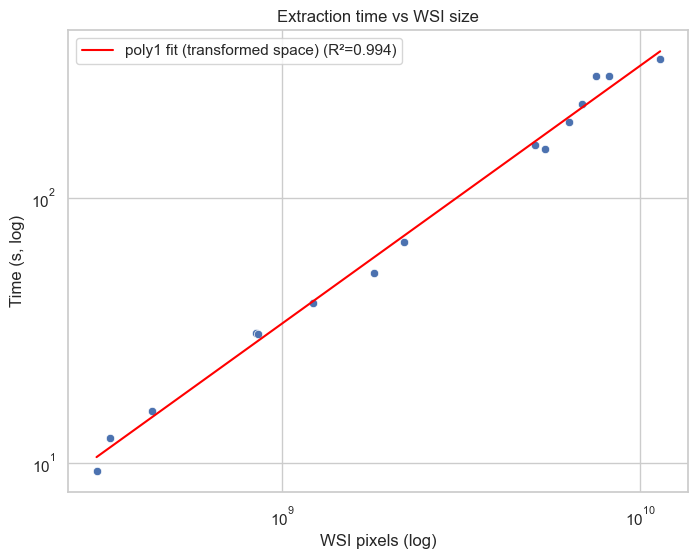

Saved plot: outputs\analyse\time_vs_mask_nonzero.png


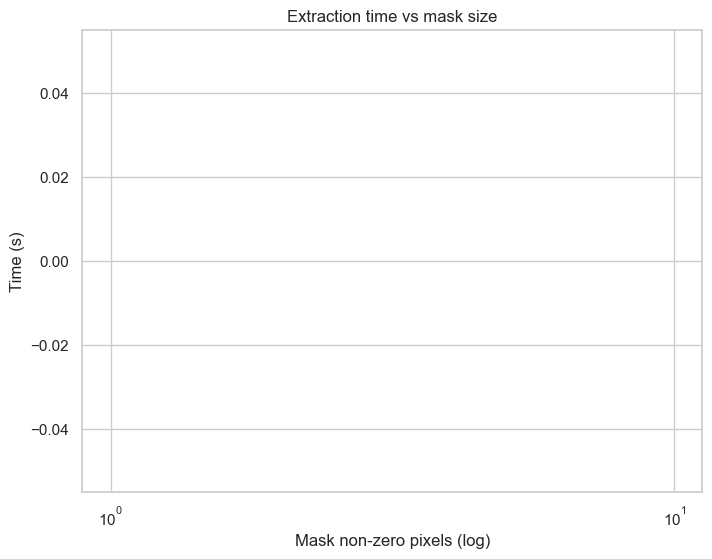

Saved plot: outputs\analyse\time_vs_num_patches.png


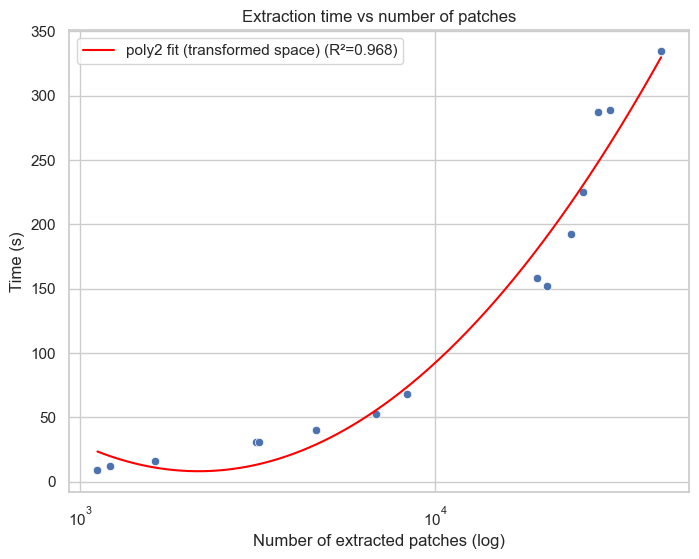


MEMORY USAGE vs SIZE PLOTS
Saved plot: outputs\analyse\memory_vs_wsi_pixels.png


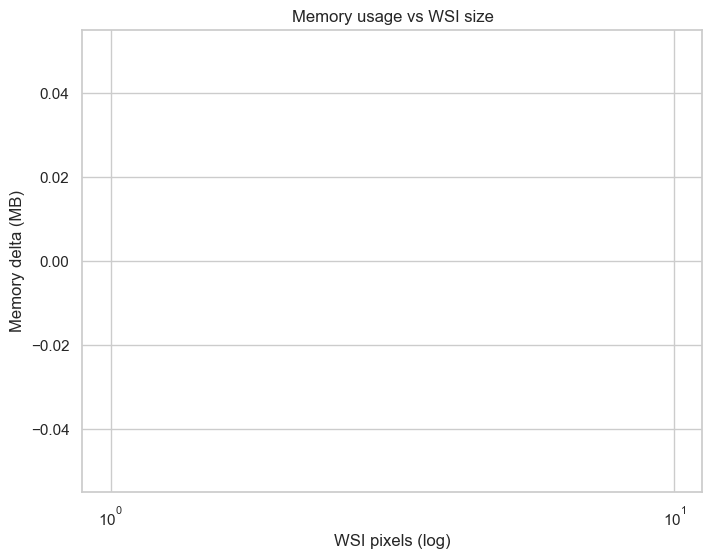

Saved plot: outputs\analyse\memory_vs_num_patches.png


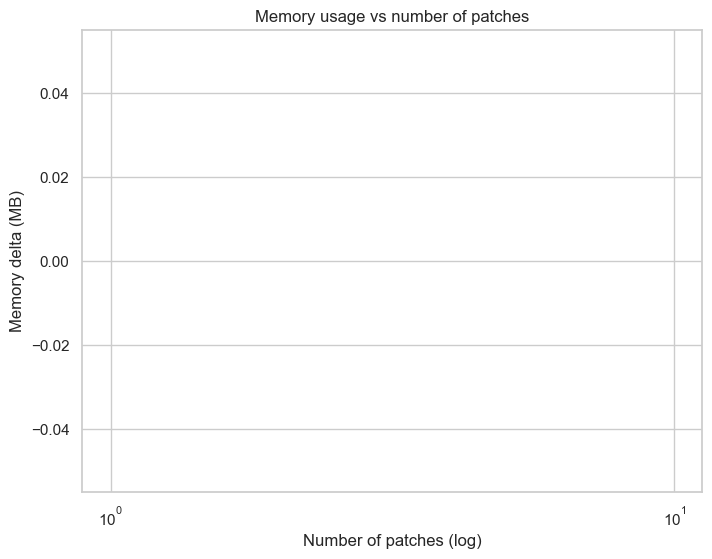

Saved plot: outputs\analyse\memory_vs_mask_nonzero.png


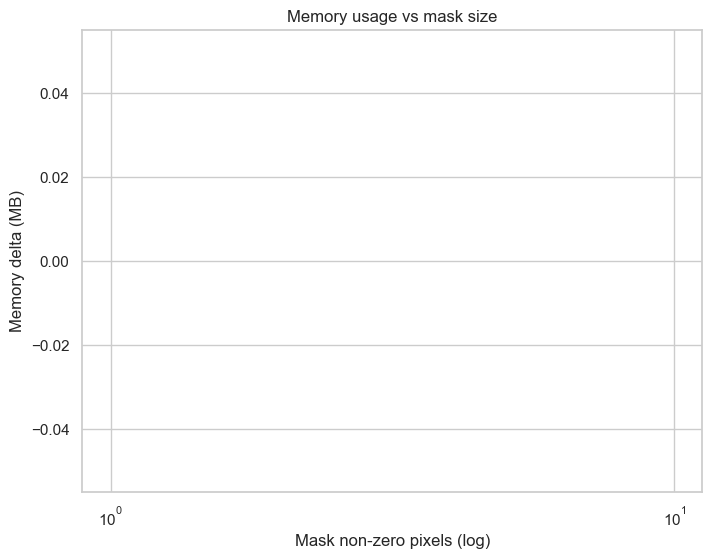


CORRELATIONS
Correlation(time_seconds, wsi_pixels) = 0.988
Not enough data to compute time correlation for mask_nonzero
Correlation(time_seconds, num_patches) = 0.988

All plots saved to outputs\analyse


In [6]:
# Plotting and visualization cell with best-fit lines (auto-detect curved relationships)
# Reads the CSV produced by the runner and creates plots saved to disk and displayed inline.
# Now includes memory usage analysis plots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if not CSV_OUT.exists():
    print(f"CSV not found at {CSV_OUT}. Run the runner cell first.")
else:
    df = pd.read_csv(CSV_OUT)

    # Basic cleaning / type conversions - only convert columns that exist
    for c in ['time_seconds', 'wsi_pixels', 'mask_nonzero', 'num_patches', 
              'mem_rss_delta', 'mem_vms_delta', 'mem_percent_delta']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Convert memory deltas to MB for better readability
    if 'mem_rss_delta' in df.columns:
        df['mem_rss_delta_mb'] = df['mem_rss_delta'] / (1024 * 1024)
    if 'mem_vms_delta' in df.columns:
        df['mem_vms_delta_mb'] = df['mem_vms_delta'] / (1024 * 1024)

    # Helper to compute and plot fits; supports 'power', 'logx_linear', 'linear', 'poly', and 'auto' (choose linear vs quadratic)
    def plot_with_fit(x, y, ax, log_x=False, log_y=False, fit_type='auto', degree=1):
        x = np.asarray(x)
        y = np.asarray(y)
        # Remove invalid / zero entries for log transforms
        mask = (~np.isnan(x)) & (~np.isnan(y))
        if log_x:
            mask &= (x > 0)
        if log_y:
            mask &= (y > 0)
        xv = x[mask]
        yv = y[mask]
        if len(xv) < 2:
            return None

        # Prepare transformed variables depending on options
        if log_x:
            tx = np.log10(xv)
        else:
            tx = xv.astype(float)
        if log_y:
            ty = np.log10(yv)
        else:
            ty = yv.astype(float)

        def compute_r2(y_true, y_pred):
            # fallback to 1 - SSR/SST if corr gives nan
            try:
                r = np.corrcoef(y_true, y_pred)[0, 1]
                if np.isnan(r):
                    raise Exception
                return float(r ** 2)
            except Exception:
                ssr = np.sum((y_true - y_pred) ** 2)
                sst = np.sum((y_true - np.mean(y_true)) ** 2)
                return float(1 - ssr / sst) if sst != 0 else 0.0

        # plotting grid
        if log_x:
            x_fit_raw = np.logspace(np.log10(xv.min()), np.log10(xv.max()), 300)
            tx_fit = np.log10(x_fit_raw)
        else:
            x_fit_raw = np.linspace(xv.min(), xv.max(), 300)
            tx_fit = x_fit_raw

        # Fit strategies
        selected = fit_type
        if fit_type == 'power' and log_x and log_y:
            # log-log linear => power law
            coeffs = np.polyfit(tx, ty, 1)
            ty_pred = np.polyval(coeffs, tx)
            r2 = compute_r2(ty, ty_pred)
            ty_fit = np.polyval(coeffs, tx_fit)
            ax.plot(x_fit_raw, (10 ** ty_fit), color='red',
                    label=f'power fit: y={10**coeffs[1]:.2e} x^{coeffs[0]:.2f} (R²={r2:.3f})')
            return ('power', coeffs, r2)

        if fit_type == 'logx_linear' and log_x and not log_y:
            # y = a * log10(x) + b  (degree=1 in tx)
            coeffs = np.polyfit(tx, ty, 1)
            ty_pred = np.polyval(coeffs, tx)
            r2 = compute_r2(ty, ty_pred)
            ty_fit = np.polyval(coeffs, tx_fit)
            ax.plot(x_fit_raw, ty_fit, color='red',
                    label=f'fit: y={coeffs[0]:.3f} log10(x)+{coeffs[1]:.3f} (R²={r2:.3f})')
            return ('logx_linear', coeffs, r2)

        # For poly or auto, operate in transformed space (tx, ty)
        if fit_type in ('poly', 'linear', 'auto'):
            # try degree 1 and degree (provided) or 2 for auto comparison
            deg1 = 1
            deg2 = degree if fit_type == 'poly' else 2

            coeffs1 = np.polyfit(tx, ty, deg1)
            ty_pred1 = np.polyval(coeffs1, tx)
            r2_1 = compute_r2(ty, ty_pred1)

            coeffs2 = np.polyfit(tx, ty, deg2)
            ty_pred2 = np.polyval(coeffs2, tx)
            r2_2 = compute_r2(ty, ty_pred2)

            pick_deg = deg1
            coeffs_pick = coeffs1
            r2_pick = r2_1

            if fit_type == 'poly':
                pick_deg = degree
                coeffs_pick = coeffs2 if degree == deg2 else coeffs1
                r2_pick = r2_2 if degree == deg2 else r2_1
            else:  # auto: choose quadratic if it improves R2 by > 0.01
                if (r2_2 - r2_1) > 0.01:
                    pick_deg = deg2
                    coeffs_pick = coeffs2
                    r2_pick = r2_2

            # compute fit curve and label
            ty_fit = np.polyval(coeffs_pick, tx_fit)
            if log_y:
                y_fit = 10 ** ty_fit
            else:
                y_fit = ty_fit
            ax.plot(x_fit_raw, y_fit, color='red',
                    label=f'poly{pick_deg} fit (transformed space) (R²={r2_pick:.3f})')
            return (f'poly{pick_deg}', coeffs_pick, r2_pick)

        # fallback: simple linear in original space
        coeffs = np.polyfit(xv, yv, 1)
        y_pred = np.polyval(coeffs, xv)
        r2 = compute_r2(yv, y_pred)
        x_fit = np.linspace(xv.min(), xv.max(), 200)
        y_fit = np.polyval(coeffs, x_fit)
        ax.plot(x_fit, y_fit, color='red', label=f'fit: y={coeffs[0]:.3e}x+{coeffs[1]:.3e} (R²={r2:.3f})')
        return ('linear', coeffs, r2)

    # Utility to attempt plotting only when column exists and has sufficient valid points
    def try_scatter_and_fit(x_col, y_col='time_seconds', log_x=False, log_y=False, xlabel=None, ylabel=None, title=None, outname=None, fit_type='auto'):
        if x_col not in df.columns:
            print(f"Skipping plot for '{x_col}' — column not found in CSV.")
            return
        if y_col not in df.columns:
            print(f"Skipping plot for '{x_col}' — required '{y_col}' column not found.")
            return
        sub = df[[x_col, y_col]].dropna()
        if log_x:
            sub = sub[sub[x_col] > 0]
        if log_y:
            sub = sub[sub[y_col] > 0]
        if len(sub) < 0:
            print(f"Skipping plot for '{x_col}' — not enough valid points ({len(sub)}).")
            return

        fig, ax = plt.subplots(figsize=(8,6))
        sns.scatterplot(x=x_col, y=y_col, data=sub, ax=ax)
        if log_x:
            ax.set_xscale('log')
        if log_y:
            ax.set_yscale('log')
        ax.set_xlabel(xlabel or x_col)
        ax.set_ylabel(ylabel or (y_col + (' (log)' if log_y else '')))
        ax.set_title(title or f"{y_col} vs {x_col}")
        fit_info = plot_with_fit(sub[x_col].values, sub[y_col].values, ax, log_x=log_x, log_y=log_y, fit_type=fit_type)
        if fit_info is not None:
            ax.legend()
        if outname:
            out_path = PLOTS_DIR / outname
            fig.savefig(out_path, dpi=150, bbox_inches='tight')
            print(f"Saved plot: {out_path}")
        plt.show()

    print("=" * 60)
    print("TIME vs SIZE PLOTS")
    print("=" * 60)
    
    # Scatter: time vs WSI pixels (log-log)
    try_scatter_and_fit('wsi_pixels', y_col='time_seconds', log_x=True, log_y=True, 
                       xlabel='WSI pixels (log)', ylabel='Time (s, log)',
                       title='Extraction time vs WSI size', 
                       outname='time_vs_wsi_pixels.png', fit_type='auto')

    # Scatter: time vs mask_nonzero (log-x, linear y)
    try_scatter_and_fit('mask_nonzero', y_col='time_seconds', log_x=True, log_y=False, 
                       xlabel='Mask non-zero pixels (log)', ylabel='Time (s)',
                       title='Extraction time vs mask size', 
                       outname='time_vs_mask_nonzero.png', fit_type='auto')

    # Scatter: time vs num_patches (log-x, linear y)
    try_scatter_and_fit('num_patches', y_col='time_seconds', log_x=True, log_y=False, 
                       xlabel='Number of extracted patches (log)', ylabel='Time (s)',
                       title='Extraction time vs number of patches', 
                       outname='time_vs_num_patches.png', fit_type='auto')

    print("\n" + "=" * 60)
    print("MEMORY USAGE vs SIZE PLOTS")
    print("=" * 60)
    
    # Memory usage vs WSI size
    try_scatter_and_fit('wsi_pixels', y_col='mem_rss_delta_mb', log_x=True, log_y=False,
                       xlabel='WSI pixels (log)', ylabel='Memory delta (MB)',
                       title='Memory usage vs WSI size',
                       outname='memory_vs_wsi_pixels.png', fit_type='auto')

    # Memory usage vs number of patches
    try_scatter_and_fit('num_patches', y_col='mem_rss_delta_mb', log_x=True, log_y=False,
                       xlabel='Number of patches (log)', ylabel='Memory delta (MB)',
                       title='Memory usage vs number of patches',
                       outname='memory_vs_num_patches.png', fit_type='auto')

    # Memory usage vs mask size
    try_scatter_and_fit('mask_nonzero', y_col='mem_rss_delta_mb', log_x=True, log_y=False,
                       xlabel='Mask non-zero pixels (log)', ylabel='Memory delta (MB)',
                       title='Memory usage vs mask size',
                       outname='memory_vs_mask_nonzero.png', fit_type='auto')

    print("\n" + "=" * 60)
    print("CORRELATIONS")
    print("=" * 60)
    
    # Print simple correlations (only for existing columns)
    for c in ['wsi_pixels', 'mask_nonzero', 'num_patches']:
        if c not in df.columns:
            print(f"Skipping correlation for '{c}' — column not found.")
            continue
        # Time correlations
        valid = df[[c, 'time_seconds']].dropna()
        if len(valid) > 1:
            corr = valid[c].corr(valid['time_seconds'])
            print(f"Correlation(time_seconds, {c}) = {corr:.3f}")
        else:
            print(f"Not enough data to compute time correlation for {c}")
        
        # Memory correlations
        if 'mem_rss_delta_mb' in df.columns:
            valid_mem = df[[c, 'mem_rss_delta_mb']].dropna()
            if len(valid_mem) > 1:
                corr_mem = valid_mem[c].corr(valid_mem['mem_rss_delta_mb'])
                print(f"Correlation(mem_rss_delta_mb, {c}) = {corr_mem:.3f}")

    print(f"\n{'=' * 60}")
    print(f"All plots saved to {PLOTS_DIR}")
    print(f"{'=' * 60}")

## Reproducibility and usage

- Configure parameters in Cell 2 (imports & configuration). Default: `N_SAMPLES = 15`, `PATCH_SIZE = 512`, `STRIDE = 512`, `LEVEL = 0`, `RANDOM_SEED = 42`.
- Run cells in order:
  1) Title (informational)
  2) Imports & configuration
  3) Methods (informational)
  4) Helper functions
  5) Runner (executes sampling and benchmarking; writes CSV)
  6) Summary statistics (saves `extract_patches_benchmark_summary.csv`)
  7) Plotting (saves three PNGs)

Artifacts (for publication):
- Raw metrics CSV: `outputs/analyse/extract_patches_benchmark.csv`
- Summary + correlations CSV: `outputs/analyse/extract_patches_benchmark_summary.csv`
- Figures: `time_vs_wsi_pixels.png`, `time_vs_mask_nonzero.png`, `time_vs_num_patches.png` in `outputs/analyse/`

Environment notes:
- Requires WSI IO dependencies (e.g., OpenSlide/cuCIM) compatible with your data and `load_wsi` implementation.
- Random sampling is reproducible via `RANDOM_SEED`.
